In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


# Deep learning packages
from keras.models import Sequential
from keras.layers import LSTM, Dense

#enable IPython to display matplolib graphs
%matplotlib inline


2022-03-17 13:04:15.226292: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-17 13:04:15.226309: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from ML_classes.MLPModel import MLPModel


In [3]:
df = pd.read_csv('./data/ouput.csv')
df['tstp'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['tstp']]
#df["tstp"] = pd.to_datetime(df["tstp"])
df["energy(kWh/hh)"] = pd.to_numeric(df["energy(kWh/hh)"], downcast="float", errors="coerce")

max_value_energy = df["energy(kWh/hh)"].max()
df['energy(kWh/hh)'] = df['energy(kWh/hh)'].apply(lambda x: x / max_value_energy)
# Sorting the values
df.sort_values('tstp', inplace=True)

In [4]:
lclid_list = df['LCLid'].unique()
def find_household(identification):
    affluenthh_filt = df["LCLid"] == identification
    affluent_hh_data = df[affluenthh_filt]
    return affluent_hh_data

hh = find_household("MAC000150")
hh.pop("LCLid")
hh = hh.set_index("tstp")
hh = hh.resample("H").sum()
hh = hh.reset_index()

In [5]:
# Initiating the class
deep_learner = MLPModel(
data = hh,
Y_var = 'energy(kWh/hh)',
lag = 24,
layer_depths = [30,30],
layer_count= 2,
epochs = 20,
batch_size = 256,
train_test_split = 0.15
)

In [6]:
# Fitting the model

model = deep_learner.MLPModel()

Epoch 1/20


2022-03-17 13:04:18.575702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-17 13:04:18.576193: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-17 13:04:18.576248: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-17 13:04:18.576292: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-17 13:04:18.576333: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

66/66 [==============================] - 0s 2ms/step - loss: 0.5278 - val_loss: 0.0092
Epoch 2/20
66/66 [==============================] - 0s 795us/step - loss: 0.0082 - val_loss: 0.0089
Epoch 3/20
66/66 [==============================] - 0s 934us/step - loss: 0.0078 - val_loss: 0.0088
Epoch 4/20
66/66 [==============================] - 0s 999us/step - loss: 0.0077 - val_loss: 0.0086
Epoch 5/20
66/66 [==============================] - 0s 914us/step - loss: 0.0076 - val_loss: 0.0084
Epoch 6/20
66/66 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0083
Epoch 7/20
66/66 [==============================] - 0s 933us/step - loss: 0.0073 - val_loss: 0.0081
Epoch 8/20
66/66 [==============================] - 0s 890us/step - loss: 0.0072 - val_loss: 0.0079
Epoch 9/20
66/66 [==============================] - 0s 924us/step - loss: 0.0070 - val_loss: 0.0077
Epoch 10/20
66/66 [==============================] - 0s 908us/step - loss: 0.0069 - val_loss: 0.0076
Epoch 11/20
66

In [7]:
deep_learner.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                750       
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 1,711
Trainable params: 1,711
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Defining the lag that we used for training of the model 
lag_model = 24
# Getting the last period
ts = hh['energy(kWh/hh)'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
X, _ = deep_learner.dc.create_X_Y(ts, lag=lag_model)
# Getting the forecast
yhat = model.predict(X)

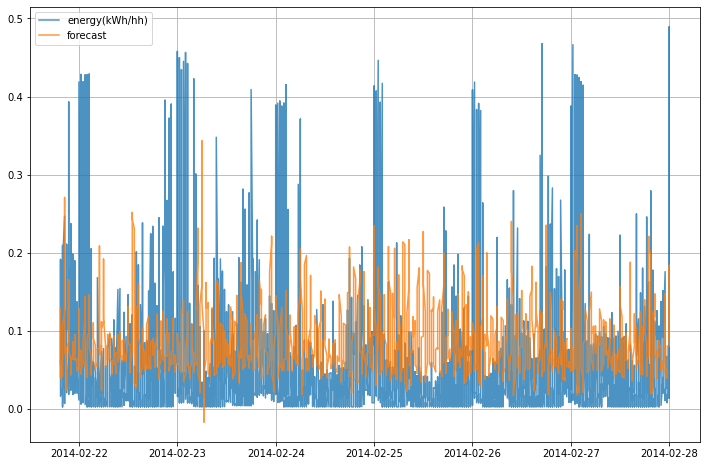

In [9]:
yhat = deep_learner.predict()
# Constructing the forecast dataframe
fc = df.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['energy(kWh/hh)', 'forecast']:
  plt.plot(
    'tstp',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()

/tmp/ipykernel_93007/2528746469.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc = fc.append(hat_frame)


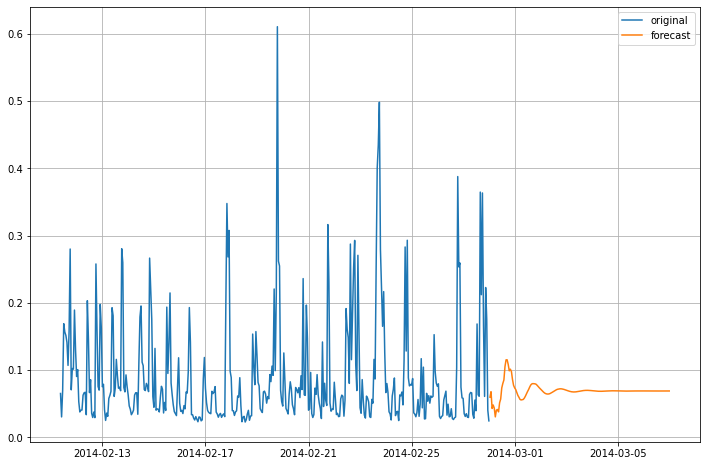

In [10]:

#Forecasting n steps ahead
n_ahead = 168
yhat = deep_learner.predict_n_ahead(n_ahead)
yhat = [y[0][0] for y in yhat]

#Constructing the forecast dataframe
fc = hh.tail(400).copy() 
fc['type'] = 'original'

last_date = max(fc['tstp'])
hat_frame = pd.DataFrame({
    'tstp': [last_date + timedelta(hours=x + 1) for x in range(n_ahead)], 
    'energy(kWh/hh)': yhat,
    'type': 'forecast'
})

fc = fc.append(hat_frame)
fc.reset_index(inplace=True, drop=True)
#Ploting the forecasts 
plt.figure(figsize=(12, 8))
for col_type in ['original', 'forecast']:
    plt.plot(
        'tstp', 
        'energy(kWh/hh)', 
        data=fc[fc['type']==col_type],
        label=col_type
        )

plt.legend()
plt.grid()   

In [11]:
deep_learner.evaluateMSE()

0.006373281896841485

In [12]:
deep_learner.evaluateRMSE()

0.07983283720901747

In [13]:
deep_learner.evaluateMAE()

0.046612033642909646

In [14]:
deep_learner.evaluateMAPE()

50.5400989304285

In [15]:
yhat =deep_learner.predict()

In [16]:
yhat

[0.12928943,
 0.09329677,
 0.08944249,
 0.059237596,
 0.039203163,
 0.063020065,
 0.041415792,
 0.04848374,
 0.049636927,
 0.08563326,
 0.087456286,
 0.08045618,
 0.07045801,
 0.090830624,
 0.101751596,
 0.106685,
 0.122762814,
 0.18213442,
 0.270708,
 0.22942817,
 0.18260589,
 0.1636036,
 0.15319562,
 0.12055731,
 0.09915061,
 0.0742417,
 0.056415897,
 0.05779585,
 0.03183916,
 0.024150606,
 0.030583378,
 0.047766205,
 0.047244336,
 0.048799153,
 0.054100465,
 0.07861933,
 0.085399196,
 0.10930021,
 0.1409932,
 0.1650485,
 0.15430991,
 0.121946916,
 0.09029238,
 0.08675875,
 0.0858684,
 0.07388465,
 0.06391248,
 0.060617562,
 0.05318145,
 0.045960557,
 0.04458728,
 0.043392595,
 0.04872374,
 0.049470376,
 0.05778822,
 0.06687522,
 0.06517896,
 0.063199475,
 0.063452125,
 0.07261644,
 0.085651636,
 0.07831107,
 0.068206355,
 0.0653263,
 0.073180795,
 0.06860235,
 0.0714066,
 0.07933141,
 0.07488893,
 0.07787728,
 0.094709665,
 0.08806439,
 0.081317455,
 0.07892834,
 0.07317063,
 0.0621

## 